In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1768119104179503995, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13997705823678001532
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7732833554371925404
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15884376474
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13314219195639252830
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.13.1


In [5]:
print(os.listdir("../input/full-keras-pretrained-no-top/"))

['mobilenet_1_0_224_tf_no_top.h5', 'nasnet_mobile_no_top.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'nasnet_large_no_top.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = '../input/icpr2012-augmented/data_augmented/data_augmented/train/'
test_dir = '../input/icpr2012-augmented/data_augmented/data_augmented/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 53114 images belonging to 6 classes.
Found 13276 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 53114
nb_validation_samples: 13276
nb_test_samples: 13578

predict_size_train: 104
predict_size_validation: 26
predict_size_test: 27

 num_classes: 6


In [11]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Xception_InceptionV3_augmented_descriptors"

In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [14]:
input_tensor = Input(shape = input_shape)  

base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [15]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [16]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[21].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[51].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[84].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[103].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[117].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[129].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[143].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[162].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[210].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[258].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[306].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[356].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[377].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[415].output
c16 = GlobalAveragePooling2D()(c16) 

c17 = model.layers[421].output
c17 = GlobalAveragePooling2D()(c17) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [18]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [19]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [20]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))

reset_keras_tf_session()

In [21]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [22]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
#                     callbacks=[es_callback],
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 53114 samples, validate on 13276 samples
Epoch 1/1000
 - 2s - loss: 1.2218 - acc: 0.5880 - val_loss: 0.8135 - val_acc: 0.7508
Epoch 2/1000
 - 1s - loss: 0.7075 - acc: 0.7845 - val_loss: 0.6869 - val_acc: 0.7790
Epoch 3/1000
 - 1s - loss: 0.6028 - acc: 0.8204 - val_loss: 0.6327 - val_acc: 0.7918
Epoch 4/1000
 - 1s - loss: 0.5438 - acc: 0.8398 - val_loss: 0.6049 - val_acc: 0.8038
Epoch 5/1000
 - 1s - loss: 0.5063 - acc: 0.8515 - val_loss: 0.5888 - val_acc: 0.8143
Epoch 6/1000
 - 1s - loss: 0.4803 - acc: 0.8605 - val_loss: 0.5518 - val_acc: 0.8206
Epoch 7/1000
 - 1s - loss: 0.4561 - acc: 0.8676 - val_loss: 0.5318 - val_acc: 0.8313
Epoch 8/1000
 - 1s - loss: 0.4388 - acc: 0.8724 - val_loss: 0.5589 - val_acc: 0.8142
Epoch 9/1000
 - 1s - loss: 0.4240 - acc: 0.8757 - val_loss: 0.5593 - val_acc: 0.8097
Epoch 10/1000
 - 1s - loss: 0.4122 - acc: 0.8801 - val_loss: 0.5326 - val_acc: 0.8267
Epoch 11/1000
 - 1s - loss: 0.4006 - acc: 0.8839 - val_loss: 0.5586 - val_acc: 0.8001
Epoch 12/1000

Epoch 96/1000
 - 1s - loss: 0.2016 - acc: 0.9477 - val_loss: 0.5881 - val_acc: 0.8478
Epoch 97/1000
 - 1s - loss: 0.2027 - acc: 0.9466 - val_loss: 0.6032 - val_acc: 0.8521
Epoch 98/1000
 - 1s - loss: 0.2009 - acc: 0.9477 - val_loss: 0.5776 - val_acc: 0.8411
Epoch 99/1000
 - 1s - loss: 0.2030 - acc: 0.9474 - val_loss: 0.5207 - val_acc: 0.8602
Epoch 100/1000
 - 1s - loss: 0.2017 - acc: 0.9480 - val_loss: 0.5983 - val_acc: 0.8457
Epoch 101/1000
 - 1s - loss: 0.2003 - acc: 0.9478 - val_loss: 0.6131 - val_acc: 0.8426
Epoch 102/1000
 - 1s - loss: 0.1996 - acc: 0.9486 - val_loss: 0.6844 - val_acc: 0.8424
Epoch 103/1000
 - 1s - loss: 0.1978 - acc: 0.9494 - val_loss: 0.6418 - val_acc: 0.8351
Epoch 104/1000
 - 1s - loss: 0.1985 - acc: 0.9489 - val_loss: 0.5901 - val_acc: 0.8442
Epoch 105/1000
 - 1s - loss: 0.1957 - acc: 0.9495 - val_loss: 0.6086 - val_acc: 0.8515
Epoch 106/1000
 - 1s - loss: 0.1980 - acc: 0.9493 - val_loss: 0.6227 - val_acc: 0.8423
Epoch 107/1000
 - 1s - loss: 0.1948 - acc: 0.94

Epoch 191/1000
 - 1s - loss: 0.1596 - acc: 0.9616 - val_loss: 0.6178 - val_acc: 0.8426
Epoch 192/1000
 - 1s - loss: 0.1593 - acc: 0.9635 - val_loss: 0.6696 - val_acc: 0.8479
Epoch 193/1000
 - 1s - loss: 0.1586 - acc: 0.9639 - val_loss: 0.6781 - val_acc: 0.8417
Epoch 194/1000
 - 1s - loss: 0.1582 - acc: 0.9635 - val_loss: 0.7365 - val_acc: 0.8548
Epoch 195/1000
 - 1s - loss: 0.1583 - acc: 0.9633 - val_loss: 0.6947 - val_acc: 0.8579
Epoch 196/1000
 - 1s - loss: 0.1591 - acc: 0.9634 - val_loss: 0.6177 - val_acc: 0.8573
Epoch 197/1000
 - 1s - loss: 0.1584 - acc: 0.9635 - val_loss: 0.5556 - val_acc: 0.8722
Epoch 198/1000
 - 1s - loss: 0.1582 - acc: 0.9634 - val_loss: 0.7104 - val_acc: 0.8548
Epoch 199/1000
 - 1s - loss: 0.1582 - acc: 0.9641 - val_loss: 0.6638 - val_acc: 0.8509
Epoch 200/1000
 - 1s - loss: 0.1558 - acc: 0.9650 - val_loss: 0.6173 - val_acc: 0.8626
Epoch 201/1000
 - 1s - loss: 0.1584 - acc: 0.9632 - val_loss: 0.7130 - val_acc: 0.8557
Epoch 202/1000
 - 1s - loss: 0.1570 - acc: 

 - 1s - loss: 0.1374 - acc: 0.9714 - val_loss: 0.7114 - val_acc: 0.8504
Epoch 286/1000
 - 1s - loss: 0.1377 - acc: 0.9716 - val_loss: 0.7404 - val_acc: 0.8524
Epoch 287/1000
 - 1s - loss: 0.1404 - acc: 0.9699 - val_loss: 0.7979 - val_acc: 0.8368
Epoch 288/1000
 - 1s - loss: 0.1401 - acc: 0.9708 - val_loss: 0.7176 - val_acc: 0.8545
Epoch 289/1000
 - 1s - loss: 0.1414 - acc: 0.9702 - val_loss: 0.6300 - val_acc: 0.8588
Epoch 290/1000
 - 1s - loss: 0.1384 - acc: 0.9707 - val_loss: 0.6867 - val_acc: 0.8507
Epoch 291/1000
 - 1s - loss: 0.1406 - acc: 0.9705 - val_loss: 0.7097 - val_acc: 0.8457
Epoch 292/1000
 - 1s - loss: 0.1370 - acc: 0.9721 - val_loss: 0.7823 - val_acc: 0.8485
Epoch 293/1000
 - 1s - loss: 0.1396 - acc: 0.9706 - val_loss: 0.7770 - val_acc: 0.8572
Epoch 294/1000
 - 1s - loss: 0.1388 - acc: 0.9711 - val_loss: 0.6463 - val_acc: 0.8553
Epoch 295/1000
 - 1s - loss: 0.1387 - acc: 0.9708 - val_loss: 0.6480 - val_acc: 0.8550
Epoch 296/1000
 - 1s - loss: 0.1398 - acc: 0.9703 - val_lo

Epoch 380/1000
 - 1s - loss: 0.1267 - acc: 0.9756 - val_loss: 0.8850 - val_acc: 0.8475
Epoch 381/1000
 - 1s - loss: 0.1303 - acc: 0.9735 - val_loss: 0.7185 - val_acc: 0.8613
Epoch 382/1000
 - 1s - loss: 0.1290 - acc: 0.9747 - val_loss: 0.7701 - val_acc: 0.8550
Epoch 383/1000
 - 1s - loss: 0.1267 - acc: 0.9765 - val_loss: 0.8262 - val_acc: 0.8514
Epoch 384/1000
 - 1s - loss: 0.1272 - acc: 0.9748 - val_loss: 0.7615 - val_acc: 0.8495
Epoch 385/1000
 - 1s - loss: 0.1295 - acc: 0.9744 - val_loss: 0.8663 - val_acc: 0.8541
Epoch 386/1000
 - 1s - loss: 0.1277 - acc: 0.9750 - val_loss: 0.8124 - val_acc: 0.8510
Epoch 387/1000
 - 1s - loss: 0.1266 - acc: 0.9751 - val_loss: 0.7638 - val_acc: 0.8555
Epoch 388/1000
 - 1s - loss: 0.1270 - acc: 0.9751 - val_loss: 0.8296 - val_acc: 0.8429
Epoch 389/1000
 - 1s - loss: 0.1266 - acc: 0.9749 - val_loss: 0.8031 - val_acc: 0.8512
Epoch 390/1000
 - 1s - loss: 0.1285 - acc: 0.9750 - val_loss: 0.7774 - val_acc: 0.8596
Epoch 391/1000
 - 1s - loss: 0.1267 - acc: 

 - 1s - loss: 0.1207 - acc: 0.9776 - val_loss: 0.8962 - val_acc: 0.8493
Epoch 475/1000
 - 1s - loss: 0.1209 - acc: 0.9772 - val_loss: 0.7954 - val_acc: 0.8498
Epoch 476/1000
 - 1s - loss: 0.1198 - acc: 0.9779 - val_loss: 0.8070 - val_acc: 0.8599
Epoch 477/1000
 - 1s - loss: 0.1202 - acc: 0.9786 - val_loss: 0.7249 - val_acc: 0.8618
Epoch 478/1000
 - 1s - loss: 0.1207 - acc: 0.9782 - val_loss: 0.7869 - val_acc: 0.8494
Epoch 479/1000
 - 1s - loss: 0.1211 - acc: 0.9771 - val_loss: 0.8077 - val_acc: 0.8531
Epoch 480/1000
 - 1s - loss: 0.1206 - acc: 0.9778 - val_loss: 0.8772 - val_acc: 0.8495
Epoch 481/1000
 - 1s - loss: 0.1193 - acc: 0.9782 - val_loss: 0.7866 - val_acc: 0.8616
Epoch 482/1000
 - 1s - loss: 0.1197 - acc: 0.9787 - val_loss: 0.8666 - val_acc: 0.8532
Epoch 483/1000
 - 1s - loss: 0.1188 - acc: 0.9787 - val_loss: 0.8023 - val_acc: 0.8521
Epoch 484/1000
 - 1s - loss: 0.1208 - acc: 0.9774 - val_loss: 0.8209 - val_acc: 0.8489
Epoch 485/1000
 - 1s - loss: 0.1187 - acc: 0.9786 - val_lo

Epoch 569/1000
 - 1s - loss: 0.1141 - acc: 0.9804 - val_loss: 0.8599 - val_acc: 0.8498
Epoch 570/1000
 - 1s - loss: 0.1149 - acc: 0.9798 - val_loss: 0.8210 - val_acc: 0.8573
Epoch 571/1000
 - 1s - loss: 0.1143 - acc: 0.9803 - val_loss: 0.8873 - val_acc: 0.8460
Epoch 572/1000
 - 1s - loss: 0.1148 - acc: 0.9805 - val_loss: 0.8777 - val_acc: 0.8460
Epoch 573/1000
 - 1s - loss: 0.1139 - acc: 0.9804 - val_loss: 0.8250 - val_acc: 0.8428
Epoch 574/1000
 - 1s - loss: 0.1157 - acc: 0.9800 - val_loss: 0.7770 - val_acc: 0.8641
Epoch 575/1000
 - 1s - loss: 0.1138 - acc: 0.9812 - val_loss: 0.8722 - val_acc: 0.8578
Epoch 576/1000
 - 1s - loss: 0.1132 - acc: 0.9804 - val_loss: 0.8988 - val_acc: 0.8607
Epoch 577/1000
 - 1s - loss: 0.1165 - acc: 0.9791 - val_loss: 0.7708 - val_acc: 0.8595
Epoch 578/1000
 - 1s - loss: 0.1131 - acc: 0.9796 - val_loss: 0.9437 - val_acc: 0.8440
Epoch 579/1000
 - 1s - loss: 0.1142 - acc: 0.9798 - val_loss: 0.8739 - val_acc: 0.8570
Epoch 580/1000
 - 1s - loss: 0.1149 - acc: 

 - 1s - loss: 0.1098 - acc: 0.9815 - val_loss: 0.8772 - val_acc: 0.8571
Epoch 664/1000
 - 1s - loss: 0.1100 - acc: 0.9815 - val_loss: 0.8718 - val_acc: 0.8506
Epoch 665/1000
 - 1s - loss: 0.1094 - acc: 0.9815 - val_loss: 0.9177 - val_acc: 0.8512
Epoch 666/1000
 - 1s - loss: 0.1105 - acc: 0.9814 - val_loss: 0.7580 - val_acc: 0.8678
Epoch 667/1000
 - 1s - loss: 0.1079 - acc: 0.9825 - val_loss: 0.8653 - val_acc: 0.8583
Epoch 668/1000
 - 1s - loss: 0.1103 - acc: 0.9809 - val_loss: 0.7983 - val_acc: 0.8643
Epoch 669/1000
 - 1s - loss: 0.1123 - acc: 0.9808 - val_loss: 0.8018 - val_acc: 0.8671
Epoch 670/1000
 - 1s - loss: 0.1092 - acc: 0.9821 - val_loss: 0.7975 - val_acc: 0.8539
Epoch 671/1000
 - 1s - loss: 0.1099 - acc: 0.9824 - val_loss: 0.8403 - val_acc: 0.8448
Epoch 672/1000
 - 1s - loss: 0.1115 - acc: 0.9808 - val_loss: 0.9616 - val_acc: 0.8408
Epoch 673/1000
 - 1s - loss: 0.1083 - acc: 0.9817 - val_loss: 0.8746 - val_acc: 0.8550
Epoch 674/1000
 - 1s - loss: 0.1112 - acc: 0.9819 - val_lo

Epoch 758/1000
 - 1s - loss: 0.1077 - acc: 0.9817 - val_loss: 0.8142 - val_acc: 0.8594
Epoch 759/1000
 - 1s - loss: 0.1050 - acc: 0.9837 - val_loss: 0.9924 - val_acc: 0.8463
Epoch 760/1000
 - 1s - loss: 0.1065 - acc: 0.9823 - val_loss: 0.9699 - val_acc: 0.8518
Epoch 761/1000
 - 1s - loss: 0.1056 - acc: 0.9835 - val_loss: 0.8525 - val_acc: 0.8543
Epoch 762/1000
 - 1s - loss: 0.1068 - acc: 0.9828 - val_loss: 0.9251 - val_acc: 0.8566
Epoch 763/1000
 - 1s - loss: 0.1062 - acc: 0.9825 - val_loss: 0.8878 - val_acc: 0.8495
Epoch 764/1000
 - 1s - loss: 0.1064 - acc: 0.9830 - val_loss: 0.8157 - val_acc: 0.8602
Epoch 765/1000
 - 1s - loss: 0.1061 - acc: 0.9832 - val_loss: 0.9194 - val_acc: 0.8443
Epoch 766/1000
 - 1s - loss: 0.1077 - acc: 0.9826 - val_loss: 0.8785 - val_acc: 0.8532
Epoch 767/1000
 - 1s - loss: 0.1076 - acc: 0.9826 - val_loss: 1.0649 - val_acc: 0.8513
Epoch 768/1000
 - 1s - loss: 0.1078 - acc: 0.9823 - val_loss: 0.8531 - val_acc: 0.8608
Epoch 769/1000
 - 1s - loss: 0.1061 - acc: 

 - 1s - loss: 0.1027 - acc: 0.9846 - val_loss: 0.8019 - val_acc: 0.8600
Epoch 853/1000
 - 1s - loss: 0.1067 - acc: 0.9826 - val_loss: 0.9039 - val_acc: 0.8544
Epoch 854/1000
 - 1s - loss: 0.1026 - acc: 0.9847 - val_loss: 0.9892 - val_acc: 0.8374
Epoch 855/1000
 - 1s - loss: 0.1049 - acc: 0.9833 - val_loss: 0.8537 - val_acc: 0.8542
Epoch 856/1000
 - 1s - loss: 0.1028 - acc: 0.9841 - val_loss: 0.7239 - val_acc: 0.8668
Epoch 857/1000
 - 1s - loss: 0.1039 - acc: 0.9840 - val_loss: 1.0034 - val_acc: 0.8491
Epoch 858/1000
 - 1s - loss: 0.1043 - acc: 0.9838 - val_loss: 0.8933 - val_acc: 0.8478
Epoch 859/1000
 - 1s - loss: 0.1045 - acc: 0.9832 - val_loss: 0.9005 - val_acc: 0.8536
Epoch 860/1000
 - 1s - loss: 0.1049 - acc: 0.9835 - val_loss: 0.9562 - val_acc: 0.8524
Epoch 861/1000
 - 1s - loss: 0.1040 - acc: 0.9835 - val_loss: 0.9164 - val_acc: 0.8537
Epoch 862/1000
 - 1s - loss: 0.1046 - acc: 0.9838 - val_loss: 0.8754 - val_acc: 0.8622
Epoch 863/1000
 - 1s - loss: 0.1042 - acc: 0.9840 - val_lo

Epoch 947/1000
 - 1s - loss: 0.1017 - acc: 0.9845 - val_loss: 1.0539 - val_acc: 0.8377
Epoch 948/1000
 - 1s - loss: 0.1028 - acc: 0.9840 - val_loss: 0.9137 - val_acc: 0.8506
Epoch 949/1000
 - 1s - loss: 0.1010 - acc: 0.9848 - val_loss: 0.8208 - val_acc: 0.8524
Epoch 950/1000
 - 1s - loss: 0.1026 - acc: 0.9840 - val_loss: 0.8570 - val_acc: 0.8567
Epoch 951/1000
 - 1s - loss: 0.1020 - acc: 0.9840 - val_loss: 0.8087 - val_acc: 0.8545
Epoch 952/1000
 - 1s - loss: 0.1008 - acc: 0.9842 - val_loss: 0.8054 - val_acc: 0.8576
Epoch 953/1000
 - 1s - loss: 0.1021 - acc: 0.9843 - val_loss: 0.8059 - val_acc: 0.8564
Epoch 954/1000
 - 1s - loss: 0.1016 - acc: 0.9847 - val_loss: 0.7630 - val_acc: 0.8663
Epoch 955/1000
 - 1s - loss: 0.1034 - acc: 0.9840 - val_loss: 0.8561 - val_acc: 0.8551
Epoch 956/1000
 - 1s - loss: 0.1015 - acc: 0.9844 - val_loss: 1.0002 - val_acc: 0.8401
Epoch 957/1000
 - 1s - loss: 0.0995 - acc: 0.9852 - val_loss: 0.7591 - val_acc: 0.8701
Epoch 958/1000
 - 1s - loss: 0.1027 - acc: 

In [24]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9181764619237001


Confusion Matrix
[[2717    2    6   11   46  144]
 [   2  493    2   11    7    4]
 [   2    4 2694   66   35  278]
 [   0   13    7 1065    7    5]
 [   7   34   34   39 2675   40]
 [  27   14  149   54   61 2823]]


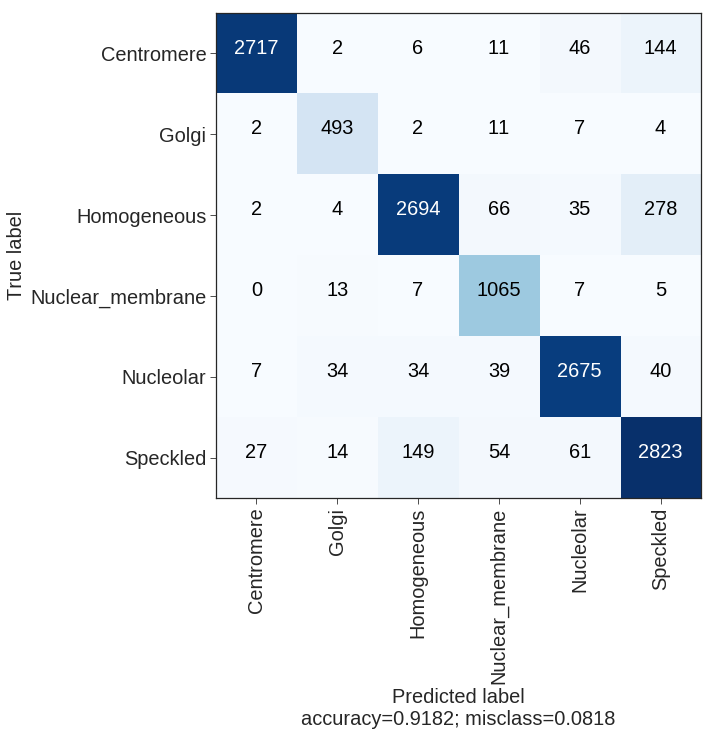

In [32]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2717    2    6   11   46  144]
 [   2  493    2   11    7    4]
 [   2    4 2694   66   35  278]
 [   0   13    7 1065    7    5]
 [   7   34   34   39 2675   40]
 [  27   14  149   54   61 2823]]
                  precision    recall  f1-score   support

      Centromere       0.99      0.93      0.96      2926
           Golgi       0.88      0.95      0.91       519
     Homogeneous       0.93      0.87      0.90      3079
Nuclear_membrane       0.85      0.97      0.91      1097
       Nucleolar       0.94      0.95      0.95      2829
        Speckled       0.86      0.90      0.88      3128

        accuracy                           0.92     13578
       macro avg       0.91      0.93      0.92     13578
    weighted avg       0.92      0.92      0.92     13578



In [34]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9992644354542111
Specificity :  0.9959595959595959


In [35]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 33us/step
Precision =  0.9207714233318245
Recall =  0.9181764619237001
f1_score =  0.9186019359719366


In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9491781515903505


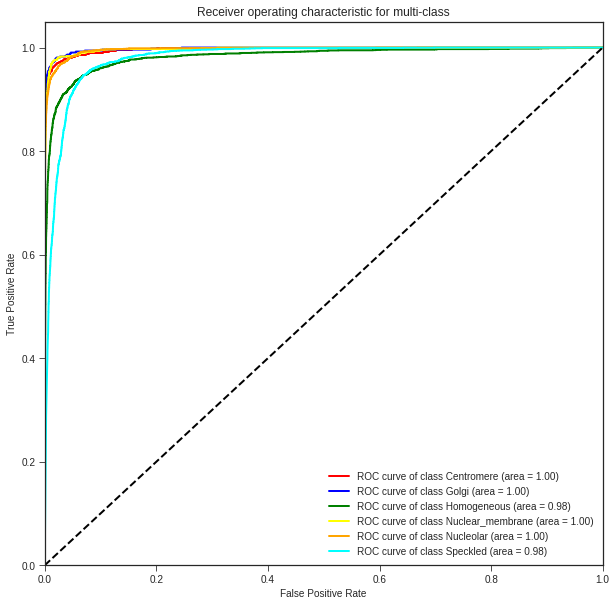

In [37]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

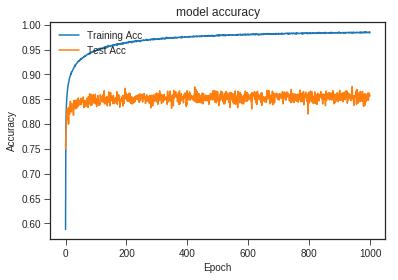

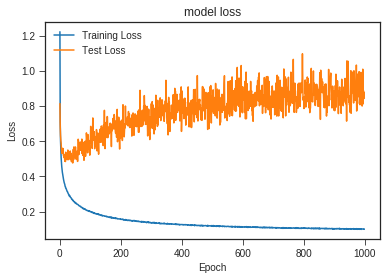

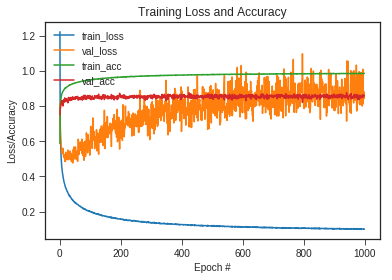

In [38]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

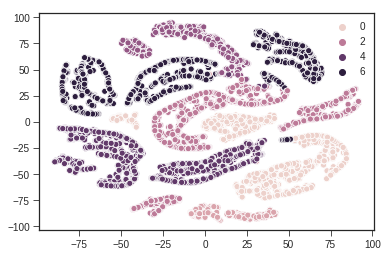

In [41]:
from sklearn.manifold import TSNE
import seaborn

model_predictions = np.vstack(preds)
classes = np.hstack(y_pred)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(model_predictions)

seaborn.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=classes)

In [42]:
print("Training Data Shape : {0}".format(train_data.shape))
print("Training Data label Shape : {0}".format(train_labels.shape))

Training Data Shape : (53114, 2944)
Training Data label Shape : (53114, 6)


In [44]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score


k_fold = KFold(n_splits=10, shuffle=True, random_state=5)

In [45]:
clf = DecisionTreeClassifier()
clf.fit(train_data, train_labels)
print("Train accuracy", clf.score(train_data, train_labels))
print("Validation accuracy", clf.score(validation_data, validation_labels ))
print("Test accuracy", clf.score(test_data, test_labels))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(test_labels, y_test_pred)
print('DecisionTree Classifier test accuracies %.4f' % (clf_test))

print(classification_report(test_labels, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(test_labels, y_test_pred))

Train accuracy 1.0
Validation accuracy 0.7210756251883097
Test accuracy 0.7663868021799971
DecisionTree Classifier test accuracies 0.7664
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2926
           1       0.58      0.80      0.67       519
           2       0.80      0.66      0.73      3079
           3       0.62      0.85      0.72      1097
           4       0.84      0.81      0.82      2829
           5       0.67      0.72      0.69      3128

   micro avg       0.77      0.77      0.77     13578
   macro avg       0.74      0.78      0.75     13578
weighted avg       0.78      0.77      0.77     13578
 samples avg       0.77      0.77      0.77     13578

0.7663868021799971


In [46]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, test_labels, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 79.1503 and (STDEV 0.0103)
Best result for fold 9
Best accuracy is 0.8076639646278556
Scores of all folds: [0.78939617 0.7820324  0.77466863 0.78939617 0.78276878 0.8011782
 0.78497791 0.79896907 0.80397937 0.80766396]
Accuracy: 0.79 (+/- 0.02)


In [47]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(train_data, train_labels)
print("Train accuracy", clf.score(train_data, train_labels))
print("Validation accuracy", clf.score(validation_data, validation_labels ))
print("Test accuracy", clf.score(test_data, test_labels))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(test_labels, y_test_pred)
print('RandomForest Classifier test accuracies %.4f' % (clf_test))

print(classification_report(test_labels, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(test_labels, y_test_pred))

Train accuracy 0.980118236246564
Validation accuracy 0.6791955408255499
Test accuracy 0.7459125055236412
RandomForest Classifier test accuracies 0.7459
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2926
           1       0.83      0.79      0.81       519
           2       0.90      0.69      0.78      3079
           3       0.84      0.82      0.83      1097
           4       0.93      0.79      0.86      2829
           5       0.76      0.66      0.70      3128

   micro avg       0.88      0.75      0.81     13578
   macro avg       0.87      0.76      0.81     13578
weighted avg       0.88      0.75      0.81     13578
 samples avg       0.75      0.75      0.75     13578

0.7459125055236412


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [48]:
clf = RandomForestClassifier(n_estimators=5)
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, test_labels, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores Mean: 77.7803 and (STDEV 0.0076)
Best result for fold 9
Best accuracy is 0.7907148120854827
Scores of all folds: [0.77982327 0.77687776 0.77172312 0.76656848 0.78792342 0.77761414
 0.78424153 0.76877761 0.77376566 0.79071481]
Accuracy: 0.78 (+/- 0.02)


In [49]:
y_test = np.asarray(test_labels)
y_test = np.argmax(y_test, axis=1)

In [50]:
y_validation = np.asarray(validation_labels)
y_validation = np.argmax(y_validation, axis=1)

In [51]:
y_train = np.asarray(train_labels)
y_train = np.argmax(y_train, axis=1)

In [52]:
clf = SVC()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Validation accuracy", clf.score(validation_data, y_validation ))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('SVM Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

Train accuracy 0.8939639266483413
Validation accuracy 0.8043838505573968
Test accuracy 0.8685373398144056
SVM Classifier test accuracies 0.8685
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2926
           1       0.79      0.90      0.84       519
           2       0.87      0.82      0.85      3079
           3       0.82      0.89      0.85      1097
           4       0.91      0.91      0.91      2829
           5       0.78      0.86      0.82      3128

    accuracy                           0.87     13578
   macro avg       0.86      0.87      0.86     13578
weighted avg       0.87      0.87      0.87     13578

0.8685373398144056


In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Validation accuracy", clf.score(validation_data, y_validation ))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('XGB Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Validation accuracy", clf.score(validation_data, y_validation ))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
clf = BaggingClassifier(RandomForestClassifier(), n_estimators = 300 )
clf.fit(train_data, y_train)
print("Train accuracy", clf.score(train_data, y_train))
print("Validation accuracy", clf.score(validation_data, y_validation ))
print("Test accuracy", clf.score(test_data, y_test))

y_test_pred = clf.predict(test_data)
clf_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost Classifier test accuracies %.4f' % (clf_test))

print(classification_report(y_test, y_test_pred))

# print(confusion_matrix(test_labels, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

In [ ]:
scoring = 'accuracy'
scores = cross_val_score(clf, test_data, y_test, cv=k_fold, n_jobs=1, scoring=scoring)

print ("Scores Mean: %.4f and (STDEV %.4f)" % (np.mean(scores)*100, np.std(scores)))
print ("Best result for fold %s" % np.argmax(scores))
print ("Best accuracy is", (scores[np.argmax(scores)]))
print ("Scores of all folds:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))